# Hands-on

## Mapping in Python

In [1]:
import geopandas
import osmnx
import contextily as cx
from geopandas_view import view
import matplotlib.pyplot as plt

In [2]:
osmnx.config(
    overpass_settings='[out:json][timeout:90][date:"2020-09-07T00:00:00Z"]'
)

In this lab, we will learn how to load, manipulate and visualize spatial data. In some senses, spatial data are usually included simply as "one more column" in a table. However, *spatial is special* sometimes and there are few aspects in which geographic data differ from standard numerical tables. In this session, we will extend the skills developed in the [previous one](../bB/lab_B) about non-spatial data, and combine them. In the process, we will discover that, although with some particularities, dealing with spatial data in Python largely resembles dealing with non-spatial data.

## Datasets

To learn these concepts, we will be playing with three main datasets. Same as in the [previous block](../bB/lab_B), these datasets can be loaded dynamically from the web, or you can download them manually, keep a copy on your computer, and load them from there.

```{admonition} Important
Make sure you are connected to the internet when you run these cells as they need to access data hosted online
```

### Cities

````{margin}
```{note}
This dataset is derived from {cite}`arribas2019building`, which proposes a machine learning algorithm to delineate city boundaries from building footprints.
```
````

First we will use a polygon geography. We will use an open dataset that contains the boundaries of Spanish cities. We can read it into an object named `cities` by:

In [3]:
cities = geopandas.read_file("https://ndownloader.figshare.com/files/20232174")

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


---

Note the code cell above requires internet connectivity. If you are not online but have a full copy of the GDS course in your computer (downloaded as suggested in the [infrastructure page](../infrastructure)), you can read the data with the following line of code: 

In [4]:
cities = geopandas.read_file("../data/web_cache/cities.gpkg")

---

(lab_C:streets)=
### Streets

````{margin}
```{note}
This dataset froms of a project called "Las calles de las mujeres", a community-driven initiative exploring the extent to which streets are named after women. 

Check out more about the project, including an interactive map at:

> [https://geochicasosm.github.io/lascallesdelasmujeres/](https://geochicasosm.github.io/lascallesdelasmujeres/)
```
````

In addition to polygons, we will play with a line layer. For that, we are going to use a subset of street network from the Spanish city of Zaragoza. 

The data is available on the following web address:

In [5]:
url = (
    "https://github.com/geochicasosm/lascallesdelasmujeres"
    "/raw/master/data/zaragoza/final_tile.geojson"
)
url

'https://github.com/geochicasosm/lascallesdelasmujeres/raw/master/data/zaragoza/final_tile.geojson'

And you can read it into an object called `streets` with:

In [6]:
streets = geopandas.read_file(url)

---

Note the code cell above requires internet connectivity. If you are not online but have a full copy of the GDS course in your computer (downloaded as suggested in the [infrastructure page](../infrastructure)), you can read the data with the following line of code: 

In [7]:
streets = geopandas.read_file("../data/web_cache/streets.gpkg")

---

### Bars

The final dataset we will rely on is a set of points demarcating the location of bars in Zaragoza. To obtain it, we will use `osmnx`, a Python library that allows us to query [OpenStreetMap](https://www.openstreetmap.org). Note that we use the method `pois_from_place`, which queries for points of interest (POIs, or `pois`) in a particular place (Zaragoza in this case). In addition, we can specify a set of tags to delimit the query. We use this to ask _only_ for amenities of the type "bar":

In [8]:
pois = osmnx.geometries_from_place(
    "Zaragoza, Spain", tags={"amenity": "bar"}
)

You do not need to know at this point what happens behind the scenes when we run `geometries_from_place` but, if you are curious, we are making a query to [OpenStreetMap](https://www.openstreetmap.org) (almost as if you typed "bars in Zaragoza, Spain" within Google Maps) and getting the response as a table of data, instead of as a website with an interactive map. Pretty cool, huh?

---

Note the code cell above requires internet connectivity. If you are not online but have a full copy of the GDS course in your computer (downloaded as suggested in the [infrastructure page](../infrastructure)), you can read the data with the following line of code: 

In [9]:
pois = geopandas.read_parquet("../data/web_cache/pois_bars_zaragoza.parquet")

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---

## Inspecting spatial data

The most direct way to get from a file to a quick visualization of the data is by loading it as a `GeoDataFrame` and calling the `plot` command. The main library employed for all of this is `geopandas` which is a geospatial extension of the `pandas` library, already introduced before. `geopandas` supports the same functionality that `pandas` does, plus a wide range of spatial extensions that make manipulation and general "munging" of spatial data similar to non-spatial tables.

In two lines of code, we will obtain a graphical representation of the spatial data contained in a file that can be in many formats; actually, since it uses the same drivers under the hood, you can load pretty much the same kind of vector files that Desktop GIS packages like QGIS permit. Let us start by plotting single layers in a crude but quick form, and we will build style and sophistication into our plots later on.

### Polygons

Now `lsoas` is a `GeoDataFrame`. Very similar to a traditional, non-spatial `DataFrame`, but with an additional column called `geometry`:

In [10]:
cities.head()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


city_id  n_building                                           geometry
0   ci000        2348  POLYGON ((385390.071 4202949.446, 384488.697 4...
1   ci001        2741  POLYGON ((214893.033 4579137.558, 215258.185 4...
2   ci002        5472  POLYGON ((690674.281 4182188.538, 691047.526 4...
3   ci003       14608  POLYGON ((513378.282 4072327.639, 513408.853 4...
4   ci004        2324  POLYGON ((206989.081 4129478.031, 207275.702 4...

This allows us to quickly produce a plot by executing the following line:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

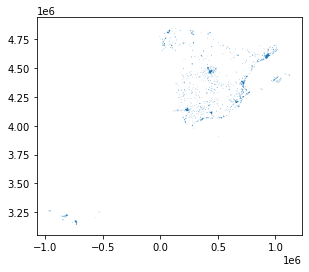

In [11]:
cities.plot()

This might not be the most aesthetically pleasant visual representation of the LSOAs geography, but it is hard to argue it is not quick to produce. We will work on styling and customizing spatial plots later on.

**Pro-tip**: if you call a single row of the `geometry` column, it'll return a small plot ith the shape:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


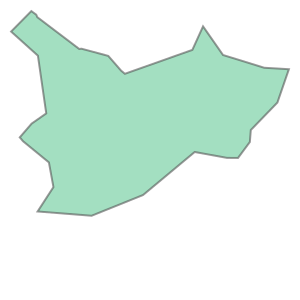

In [12]:
cities.loc[0, 'geometry']

### Lines

Similarly to the polygon case, if we pick the `"geometry"` column of a table with lines, a single row will display the geometry as well:

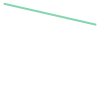

In [13]:
streets.loc[0, 'geometry']

A quick plot is similarly generated by:

<AxesSubplot:>

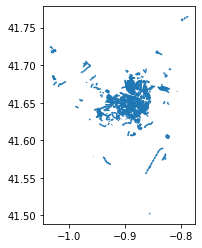

In [14]:
streets.plot()

Again, this is not the prettiest way to display the streets maybe, and you might want to change a few parameters such as colors, etc. All of this is possible, as we will see below, but this gives us a quick check of what lines look like.

### Points

Points take a similar approach for quick plotting:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

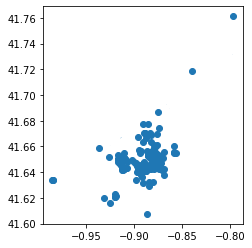

In [15]:
pois.plot()

## Styling plots

It is possible to tweak several aspects of a plot to customize if to particular needs. In this section, we will explore some of the basic elements that will allow us to obtain more compelling maps.

**NOTE**: some of these variations are very straightforward while others are more intricate and require tinkering with the internal parts of a plot. They are not necessarily organized by increasing level of complexity.

### Changing transparency

The intensity of color of a polygon can be easily changed through the `alpha` attribute in plot. This is specified as a value betwee zero and one, where the former is entirely transparent while the latter is the fully opaque (maximum intensity):

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

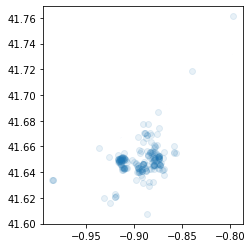

In [16]:
pois.plot(alpha=0.1)

### Removing axes

Although in some cases, the axes can be useful to obtain context, most of the times maps look and feel better without them. Removing the axes involves wrapping the plot into a figure, which takes a few more lines of aparently useless code but that, in time, it will allow you to tweak the map further and to create much more flexible designs:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


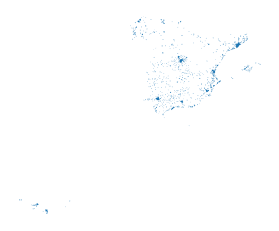

In [17]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Plot layer of polygons on the axis
cities.plot(ax=ax)
# Remove axis frames
ax.set_axis_off()
# Display
plt.show()

Let us stop for a second a study each of the previous lines:

1. We have first created a figure named `f` with one axis named `ax` by using the command `plt.subplots` (part of the library `matplotlib`, which we have imported at the top of the notebook). Note how the method is returning two elements and we can assign each of them to objects with different name (`f` and `ax`) by simply listing them at the front of the line, separated by commas.
1. Second, we plot the geographies as before, but this time we tell the function that we want it to draw the polygons on the axis we are passing, `ax`. This method returns the axis with the geographies in them, so we make sure to store it on an object with the same name, `ax`.
1. On the third line, we effectively remove the box with coordinates.
1. Finally, we draw the entire plot by calling `plt.show()`.

### Adding a title

Adding a title is an extra line, if we are creating the plot within a figure, as we just did. To include text on top of the figure:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


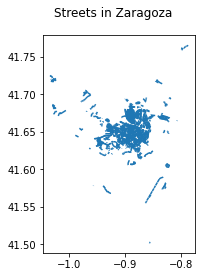

In [18]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add layer of polygons on the axis
streets.plot(ax=ax)
# Add figure title
f.suptitle("Streets in Zaragoza")
# Display
plt.show()

### Changing the size of the map

The size of the plot is changed equally easily in this context. The only difference is that it is specified when we create the figure with the argument `figsize`. The first number represents the width, the X axis, and the second corresponds with the height, the Y axis.

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


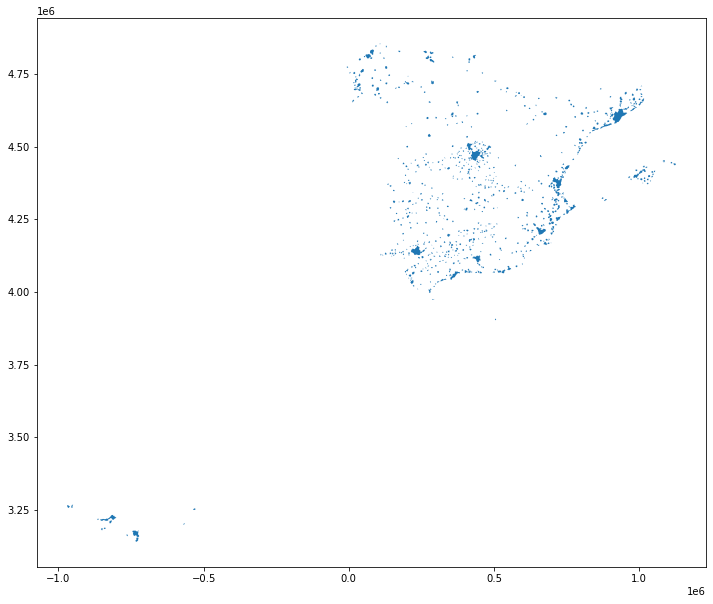

In [19]:
# Setup figure and axis with different size
f, ax = plt.subplots(1, figsize=(12, 12))
# Add layer of polygons on the axis
cities.plot(ax=ax)
# Display
plt.show()

### Modifying borders

Border lines sometimes can distort or impede proper interpretation of a map. In those cases, it is useful to know how they can be modified. Although not too complicated, the way to access borders in `geopandas` is not as straightforward as it is the case for other aspects of the map, such as size or frame. Let us first see the code to make the *lines thicker* and *black*, and then we will work our way through the different steps:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

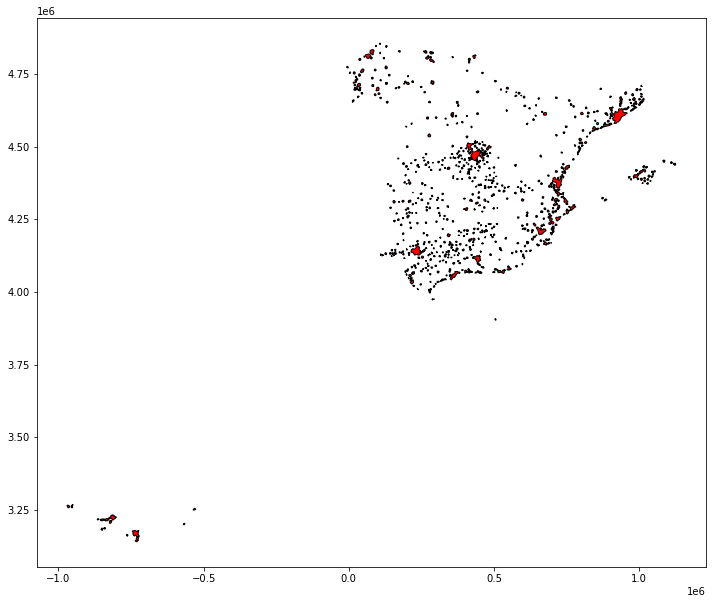

In [20]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))
# Add layer of polygons on the axis, set fill color (`facecolor`) and boundary
# color (`edgecolor`)
cities.plot(linewidth=1, 
            facecolor='red', 
            edgecolor='black', 
            ax=ax
           )

Note how the lines are thicker. In addition, all the polygons are colored in the same (default) color, light red. However, because the lines are thicker, we can only see the polygon filling for those cities with an area large enough.

Let us examine line by line what we are doing in the code snippet:

* We begin by creating the figure (`f`) object and one axis inside it (`ax`) where we will plot the map.
* Then, we call `plot` as usual, but pass in two new arguments: `linewidth` for the width of the line; `facecolor`, to control the color each polygon is filled with; and `edgecolor`, to control the color of the boundary.

This approach works very similarly with other geometries, such as lines. For example, if we wanted to plot the streets in red, we would simply:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

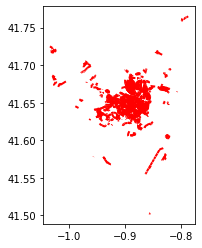

In [21]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add layer with lines, set them red and with different line width
# and append it to the axis `ax`
streets.plot(linewidth=2, color='red', ax=ax)

Important, note that in the case of lines the parameter to control the color is simply `color`. This is because lines do not have an area, so there is no need to distinguish between the main area (`facecolor`) and the border lines (`edgecolor`).

(lab_C:to_crs)=
### Transforming CRS

The coordindate reference system (CRS) is the way geographers and cartographers have to represent a three-dimentional object, such as the round earth, on a two-dimensional plane, such as a piece of paper or a computer screen. If the source data contain information on the CRS of the data, we can modify this in a `GeoDataFrame`. First let us check if we have the information stored properly:

In [22]:
cities.crs

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Projected CRS: EPSG:25830>
Name: ETRS89 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°W and 0°W: Faroe Islands offshore; Ireland - offshore; Jan Mayen - offshore; Norway including Svalbard - offshore; Spain - onshore and offshore.
- bounds: (-6.0, 35.26, 0.0, 80.53)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

As we can see, there is information stored about the reference system: it is using the standard Spanish projection, which is expressed in meters. There are also other less decipherable parameters but we do not need to worry about them right now.

If we want to modify this and "reproject" the polygons into a different CRS, the quickest way is to find the [EPSG](https://en.wikipedia.org/wiki/International_Association_of_Oil_%26_Gas_Producers#European_Petroleum_Survey_Group) code online ([epsg.io](http://epsg.io/) is a good one, although there are others too). For example, if we wanted to transform the dataset into lat/lon coordinates, we would use its EPSG code, 4326:

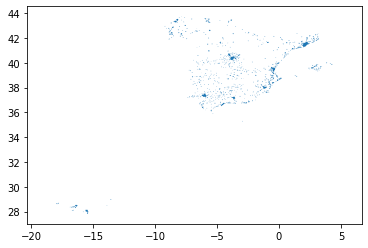

In [23]:
# Reproject (`to_crs`) and plot (`plot`) polygons
cities.to_crs(epsg=4326).plot()
# Set equal axis
lims = plt.axis('equal')

The shape of the polygons is slightly different. Furthermore, note how the *scale* in which they are plotted differs.

## Composing multi-layer maps

So far we have considered many aspects of plotting *a single* layer of data. However, in many cases, an effective map will require more than one: for example we might want to display streets on top of the polygons of neighborhoods, and add a few points for specific locations we want to highlight. At the very heart of GIS is the possibility to combine spatial information from different sources by overlaying it on top of each other, and this is fully supported in Python.

For this section, let's select only Zaragoza from the `streets` table and convert it to lat/lon so it's aligned with the streets and POIs layers:

In [24]:
zgz = cities.loc[[112], :].to_crs(epsg=4326)
zgz

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


city_id  n_building                                           geometry
112   ci122       23604  POLYGON ((-0.93057 41.60615, -0.93092 41.60622...

Combining different layers on a single map boils down to adding each of them to the same axis in a sequential way, as if we were literally overlaying one on top of the previous one. For example, let's plot the boundary of Zaragoza and its bars:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

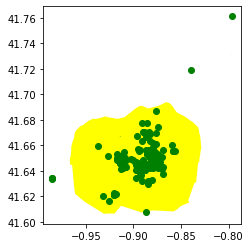

In [25]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add a layer with polygon on to axis `ax`
zgz.plot(ax=ax, color="yellow")
# Add a layer with lines on top in axis `ax`
pois.plot(ax=ax, color="green")

## Saving maps to figures

Once we have produced a map we are content with, we might want to save it to a file so we can include it into a report, article, website, etc. Exporting maps in Python involves replacing `plt.show` by `plt.savefig` at the end of the code block to specify where and how to save it. For example to save the previous map into a `png` file in the same folder where the notebook is hosted:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


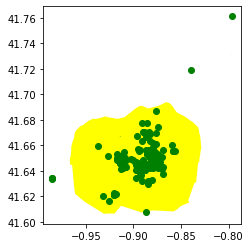

In [26]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add a layer with polygon on to axis `ax`
zgz.plot(ax=ax, color="yellow")
# Add a layer with lines on top in axis `ax`
pois.plot(ax=ax, color="green")
# Save figure to a PNG file
plt.savefig('zaragoza_bars.png')

If you now check on the folder, you'll find a `png` (image) file with the map.

The command `plt.savefig` contains a large number of options and additional parameters to tweak. Given the size of the figure created is not very large, we can increase this with the argument `dpi`, which stands for "dots per inch" and it's a standard measure of resolution in images. For example, for a high quality image, we could use 500:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


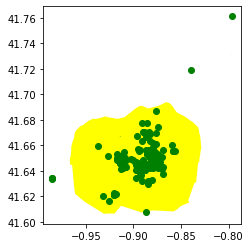

In [27]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add a layer with polygon on to axis `ax`
zgz.plot(ax=ax, color="yellow")
# Add a layer with lines on top in axis `ax`
pois.plot(ax=ax, color="green")
# Save figure to a PNG file
plt.savefig('zaragoza_bars.png', dpi=500)

## Manipulating spatial tables (`GeoDataFrames`)

Once we have an understanding of how to visually display spatial information contained, let us see how it can be combined with the operations learnt in the previous session about manipulating non-spatial tabular data. Essentially, the key is to realize that a `GeoDataFrame` contains most of its spatial information in a single column named `geometry`, but the rest of it looks and behaves exactly like a non-spatial `DataFrame` (in fact, it is). This concedes them all the flexibility and convenience that we saw in manipulating, slicing, and transforming tabular data, with the bonus that spatial data is carried away in all those steps. In addition, `GeoDataFrames` also incorporate a set of explicitly spatial operations to combine and transform data. In this section, we will consider both.

`GeoDataFrame`s come with a whole range of traditional GIS operations built-in. Here we will run through a small subset of them that contains some of the most commonly used ones.

### Area calculation

One of the spatial aspects we often need from polygons is their area. "How big is it?" is a question that always haunts us when we think of countries, regions, or cities. To obtain area measurements, first make sure you `GeoDataFrame` {ref}`is projected <lab_C:to_crs>`. If that is the case, you can calculate areas as follows:

In [28]:
city_areas = cities.area
city_areas.head()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    8.449666e+06
1    9.121270e+06
2    1.322653e+07
3    6.808121e+07
4    1.072284e+07
dtype: float64

This indicates that the area of the first city in our table takes up 8,450,000 squared metres. If we wanted to convert into squared kilometres, we can divide by 1,000,000:

In [29]:
areas_in_sqkm = city_areas / 1000000
areas_in_sqkm.head()

0     8.449666
1     9.121270
2    13.226528
3    68.081212
4    10.722843
dtype: float64

(lab_C:length)=
### Length

Similarly, an equally common question with lines is their length. Also similarly, their computation is relatively straightforward in Python, provided that our data are projected. Here we will perform the projection (`to_crs`) and the calculation of the length at the same time:

In [30]:
street_length = streets.to_crs(epsg=25830).length
street_length.head()

0     37.338828
1    104.510732
2    365.969719
3     97.101436
4     94.002218
dtype: float64

Since the CRS we use (`EPSG:25830`) is expressed in metres, we can tell the first street segment is about 37m.

### Centroid calculation

Sometimes it is useful to summarize a polygon into a single point and, for that, a good candidate is its centroid (almost like a spatial analogue of the average). The following command will return a `GeoSeries` (a single column with spatial data) with the centroids of a polygon `GeoDataFrame`:

In [31]:
cents = cities.centroid
cents.head()

0    POINT (386147.759 4204605.994)
1    POINT (216296.159 4579397.331)
2    POINT (688901.588 4180201.774)
3    POINT (518262.028 4069898.674)
4    POINT (206940.936 4127361.966)
dtype: geometry

Note how `cents` is not an entire table but a single column, or a `GeoSeries` object. This means you can plot it directly, just like a table:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

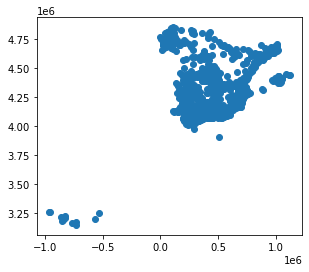

In [32]:
cents.plot()

But you don't need to call a `geometry` column to inspect the spatial objects. In fact, if you do it will return an error because there is not any `geometry` column, the object `cents` itself is the geometry.

### Point in polygon (PiP)

Knowing whether a point is inside a polygon is conceptually a straightforward exercise but computationally a tricky task to perform. The way to perform this operation in `GeoPandas` is through the `contains` method, available for each polygon object.

In [33]:
poly = cities.loc[112, "geometry"]
pt1 = cents[0]
pt2 = cents[112]

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


And we can perform the checks as follows:

In [34]:
poly.contains(pt1)

False

In [35]:
poly.contains(pt2)

True

Performing point-in-polygon in this way is instructive and useful for pedagogical reasons, but for cases with many points and polygons, it is not particularly efficient. In these situations, it is much more advisable to perform then as a "spatial join". If you are interested in these, see the link provided below to learn more about them.

### Buffers

Buffers are one of the classical GIS operations in which an area is drawn around a particular geometry, given a specific radious. These are very useful, for instance, in combination with point-in-polygon operations to calculate accessibility, catchment areas, etc.

For this example, we will use the bars table, but will project it to the same CRS as `cities`, so it is expressed in metres:

In [36]:
pois_projected = pois.to_crs(cities.crs)
pois_projected.crs

<Projected CRS: EPSG:25830>
Name: ETRS89 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°W and 0°W: Faroe Islands offshore; Ireland - offshore; Jan Mayen - offshore; Norway including Svalbard - offshore; Spain - onshore and offshore.
- bounds: (-6.0, 35.26, 0.0, 80.53)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

To create a buffer using `geopandas`, simply call the `buffer` method, passing in the radious. For example, to draw a 500m. buffer around every bar in Zaragoza:

In [37]:
buf = pois_projected.buffer(500)
buf.head()

0    POLYGON ((676071.164 4612191.116, 676068.756 4...
1    POLYGON ((675740.197 4612333.309, 675737.789 4...
2    POLYGON ((676083.551 4614558.818, 676081.143 4...
3    POLYGON ((675653.012 4611997.279, 675650.604 4...
4    POLYGON ((675616.277 4614955.710, 675613.870 4...
dtype: geometry

And plotting it is equally straighforward:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

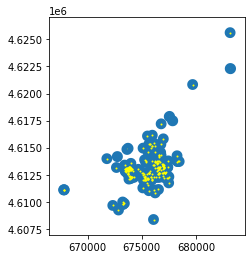

In [38]:
f, ax = plt.subplots(1)
# Plot buffer
buf.plot(ax=ax, linewidth=0)
# Plot named places on top for reference
# [NOTE how we modify the dot size (`markersize`)
# and the color (`color`)]
pois_projected.plot(ax=ax, markersize=1, color='yellow')

## Adding base layers from web sources

Many single datasets lack context when displayed on their own. A common approach to alleviate this is to use web tiles, which are a way of quickly obtaining geographical context to present spatial data. In Python, we can use [`contextily`](https://contextily.readthedocs.io) to pull down tiles and display them along with our own geographic data.

We can begin by creating a map in the same way we would do normally, and then use the `add_basemap` command to, er, add a basemap:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


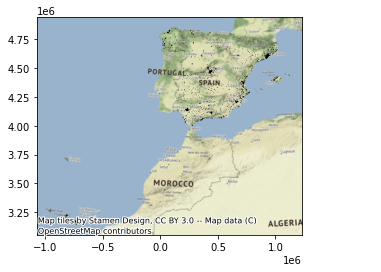

In [39]:
ax = cities.plot(color="black")
cx.add_basemap(ax, crs=cities.crs);

Note that we need to be explicit when adding the basemap to state the coordinate reference system (`crs`) our data is expressed in, `contextily` will not be able to pick it up otherwise. Conversely, we could change our data's CRS into [Pseudo-Mercator](http://epsg.io/3857), the native reference system for most web tiles:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


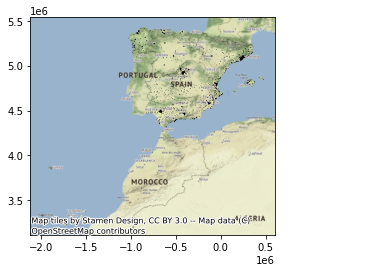

In [40]:
cities_wm = cities.to_crs(epsg=3857)
ax = cities_wm.plot(color="black")
cx.add_basemap(ax);

Note how the coordinates are different but, if we set it right, either approach aligns tiles and data nicely.

Web tiles can be integrated with other features of maps in a similar way as we have seen above. So, for example, we can change the size of the map, and remove the axis. Let's use Zaragoza for this example:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


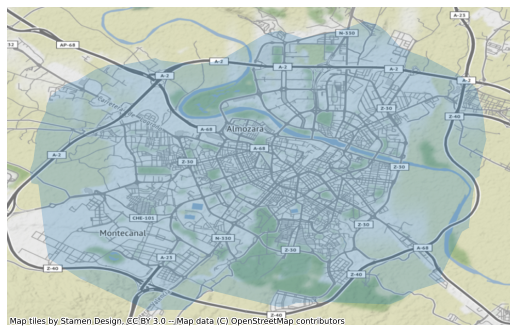

In [41]:
f, ax = plt.subplots(1, figsize=(9, 9))
zgz.plot(alpha=0.25, ax=ax)
cx.add_basemap(ax, crs=zgz.crs)
ax.set_axis_off()

Now, `contextily` offers a lot of options in terms of the sources and providers you can use to create your basemaps. For example, we can use satellite imagery instead:

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


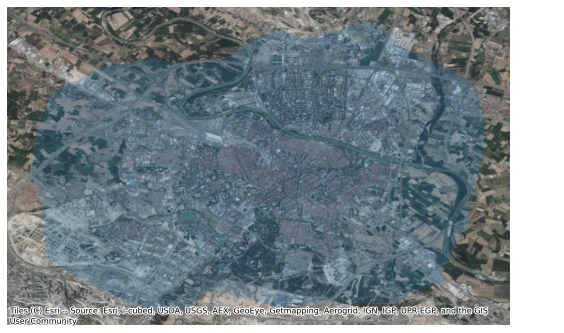

In [42]:
f, ax = plt.subplots(1, figsize=(9, 9))
zgz.plot(alpha=0.25, ax=ax)
cx.add_basemap(ax, 
               crs=zgz.crs,
               source=cx.providers.Esri.WorldImagery
              )
ax.set_axis_off()

Have a look at this Twitter thread to get some further ideas on providers:

In [43]:
from IPython.display import HTML
tweet = """
<blockquote class="twitter-tweet" data-lang="en"><p lang="et" dir="ltr">Terrain maps <a href="https://t.co/VtN9bGG5Mt">pic.twitter.com/VtN9bGG5Mt</a></p>&mdash; Dani Arribas-Bel (@darribas) <a href="https://twitter.com/darribas/status/1157297596689539072?ref_src=twsrc%5Etfw">August 2, 2019</a></blockquote>
<script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
"""
HTML(tweet)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


And consider checking out the documentation website for the package:

> [https://contextily.readthedocs.io/en/latest/](https://contextily.readthedocs.io/en/latest/)

## Interactive maps

Everything we have seen so far relates to static maps. These are useful for publication, to include in reports or to print. However, modern web technologies afford much more flexibility to explore spatial data interactively.

We will use the state-of-the-art Leaflet integration into `geopandas`. This integration connects `GeoDataFrame` objects with the popular web mapping library Leaflet.js. In this context, we will only show how you can take a `GeoDataFrame` into an interactive map in one line of code:

In [44]:
# Display interactive map
view(streets)

## Further resources

More advanced GIS operations are possible in `geopandas` and, in most cases, they are extensions of the same logic we have used in this document. If you are thinking about taking the next step from here, the following two operations (and the documentation provided) will give you the biggest ["bang for the buck"](https://en.wikipedia.org/wiki/Bang_for_the_buck):

* Spatial joins

> [https://geopandas.org/mergingdata.html#spatial-joins](https://geopandas.org/mergingdata.html#spatial-joins)

* Spatial overlays

> [https://geopandas.org/set_operations.html](https://geopandas.org/set_operations.html)